- **Author:** [Dace Apšvalka](https://www.mrc-cbu.cam.ac.uk/people/dace.apsvalka/) 
- **Date:** August 2026  
- **conda environment**: [mri conda environment](../mri_environment.yml).

# fMRI Data Analysis: Subject-Level Analysis

Once the data have been pre-processed, we can proceed to the analysis. In this tutorial, we will focus on subject-level (or first-level) fMRI data analysis using [Nilearn](https://nilearn.github.io/stable/index.html). This process involves:  
 - constructing a design matrix, 
 - fitting the model to the data, and 
 - computing beta maps (i.e., the estimated response for each condition) or contrast maps. 

Subject-level analysis is a crucial step before progressing to group-level analysis.

For analysing fMRI data, we commonly use general linear model (GLM). A GLM in fMRI analysis has the **BOLD signal** as the **outcome** variable (derived from the pre-processed functional MRI images) and **predictor** variables such as **events** (e.g., task conditions) and **confounds** (e.g., motion parameters). Typically analysis is performed by constructing a separate model for each voxel - **a mass univariate approach**. 

For more information on GLM, please see [Rik's Stats tutorial](https://github.com/RikHenson/Stats4Imaging).

And here are some recommended short videos to help better understand the principles of fMRI analysis:

In [1]:
from IPython.display import display, HTML

display(HTML('''
<div style="width: 1200px; margin: 0; display: flex; justify-content: space-around;">
    <div style="text-align: center;">
        <h3><a href="https://www.youtube.com/embed/OyLKMb9FNhg">GLM applied to fMRI (11 min)</a></h3>
        <iframe width="560" height="315" src="https://www.youtube.com/embed/OyLKMb9FNhg" frameborder="0" allow="picture-in-picture" allowfullscreen></iframe>
    </div>
    <div style="text-align: center;">
        <h3><a href="https://www.youtube.com/embed/7MibM1ATai4">Conditions and contrasts (12 min)</a></h3>
        <iframe width="560" height="315" src="https://www.youtube.com/embed/7MibM1ATai4" frameborder="0" allow="picture-in-picture" allowfullscreen></iframe>
    </div>
</div>

<div style="width: 1200px; margin: 0; display: flex; justify-content: space-around;">
    <div style="text-align: center;">
        <h3><a href="https://www.youtube.com/embed/DEtwsFdFwYc">Nuisance variables (14 min)</a></h3>
        <iframe width="560" height="315" src="https://www.youtube.com/embed/DEtwsFdFwYc" frameborder="0" allow="picture-in-picture" allowfullscreen></iframe>
    </div>
    <div style="text-align: center;">
        <h3><a href="https://www.youtube.com/embed/AalIM9-5-Pk">Multiple Comparisons (9 min)</a></h3>
        <iframe width="560" height="315" src="https://www.youtube.com/embed/AalIM9-5-Pk" frameborder="0" allow="picture-in-picture" allowfullscreen></iframe>
    </div>
</div>
'''))


----------------
**Table of contents**    
1. Import required packages   
2. Retrieve the preprocessed (fMRIprep) data   
3. Setting up GLM model components   
3.1. Dependent variable (Y): BOLD signal from each voxel of the functional MRI images    
3.2. Predictors (X): Events    
3.3. Predictors: Confounds    
4. Performing the GLM analysis    
4.1. Creating the First Level Model  
4.2. Fitting the model   
4.3. Inspecting the Design Matrix    
5. Contrast specification    
5.1. A simple case contrast    
5.2. Contrast scaling    
5.3. The final contrasts for our model    
6. Computing contrasts and plotting result maps    
6.1. Control the False Positive Rate    
6.2. False Discovery Rate (FDR) correction    
6.3. Family Wise Error (FWE) correction    
6.4. Cluster threshold      
7. First Level for multiple subjects    
7.1. A generic first-level analysis script    
7.2. Processing multiple subjects in parallel   

-----------
## Import required packages

In [ ]:
import pandas as pd # for data manipulation
import numpy as np # for numerical operations

import matplotlib.pyplot as plt # for basic plotting

from bids import BIDSLayout # to fetch data from BIDS-compliant datasets

# Nilearn modules, for the analysis of brain volumes, plotting, etc., https://nilearn.github.io/
from nilearn.glm.first_level import FirstLevelModel, compute_regressor, glover_hrf, spm_hrf
from nilearn.glm.thresholding import threshold_stats_img
from nilearn.plotting import plot_design_matrix, plot_contrast_matrix, plot_stat_map
from nilearn.maskers import NiftiSpheresMasker

import nibabel as nib # to load and save neuroimaging data

## Retrieve the preprocessed (fMRIprep) data

BIDS Apps, such as `fMRIprep`, output data into a data structure similar to `BIDS` organisation principals. And these data also can be inspected using [PyBIDS](https://bids-standard.github.io/pybids/index.html).

In [3]:
# --- Set up the paths to the BIDS data directory which includes derivatives
fmri_data_dir = '../example_data/FaceRecognition/data' # BIDS format data directory

# --- Set up the BIDS layoutt and include the derivatives in it
layout = BIDSLayout(fmri_data_dir, derivatives = True)

# or to include only a specific derivatives folder
# layout = BIDSLayout(fmri_data_dir, derivatives = 'path/to/derivatives')


## Setting up GLM model components

Remember (or refer to [Rik's stats](https://github.com/RikHenson/Stats4Imaging)) that GLM typically is expressed as **Y = XB + e**, where **Y** is a vector containing the data, **X** is the 'design matrix' that defines the model for the data, **B** (or 'Betas') is a vector of parameters to be estimated, and **e** represents random error.

In the next sections, we will set up our GLM model by specifying the following:
* **The data (Y)**, which are our pre-processed functional images. These contain the time series data (length n; 208 in our case) for each voxel.
* **The design matrix (X)**, where we specify the effects (predictors) that may have influenced the acquired signal in the data. At a minimum, these effects include our experimental conditions, which we specify through event files containing the names and onsets of the conditions. Additionally, we can include other predictors, such as confounding (nuisance) variables, which are known to have occurred and likely influenced the data. Including these can help explain the acquired signal. We get a large list of confounding variables from the fMRIPrep output (confound files). The size of the design matrix must be n x p (time series length x number of predictors). There should be more data points (n) than predictors (p), so be cautious not to include too many confounding variables.

Nilearn will use the specified inputs for the GLM analysis and compute the beta estimates for each predictor. We can then define contrasts to compare beta estimates between conditions—for example, to test whether seeing Faces had a greater effect on the signal than seeing Scrambled images.

Let's set up our GLM model.

### Dependent variable (Y): BOLD signal from each voxel of the functional MRI images

We need to specify which MRI images we want to analyse. Here, we will focus on a single subject's **9 functional runs**. Using PyBIDS, we can easily locate the preprocessed files required for the analysis. Let's retrieve the preprocessed functional image files for **subject sub-15** (since this is the subject used for demo of [SPM-Matlab analysis of this dataset](https://doi.org/10.3389/fnins.2019.00300)).

In [4]:
sID = '15'

preproc_functional_files = layout.get(
    subject = sID, 
    datatype = 'func', 
    desc = 'preproc', 
    space = 'MNI152NLin6Asym',
    extension = '.nii.gz',
    return_type = 'filename'
)

print('\nSubject''s', sID, 'preprocessed functional images:')
print(*preproc_functional_files, sep='\n')


Subjects 15 preprocessed functional images:
/imaging/correia/da05/workshops/2026-CBU/notebooks/../example_data/FaceRecognition/data/derivatives/fmriprep/sub-15/ses-mri/func/sub-15_ses-mri_task-facerecognition_run-01_space-MNI152NLin6Asym_res-9_desc-preproc_bold.nii.gz
/imaging/correia/da05/workshops/2026-CBU/notebooks/../example_data/FaceRecognition/data/derivatives/fmriprep/sub-15/ses-mri/func/sub-15_ses-mri_task-facerecognition_run-02_space-MNI152NLin6Asym_res-9_desc-preproc_bold.nii.gz
/imaging/correia/da05/workshops/2026-CBU/notebooks/../example_data/FaceRecognition/data/derivatives/fmriprep/sub-15/ses-mri/func/sub-15_ses-mri_task-facerecognition_run-03_space-MNI152NLin6Asym_res-9_desc-preproc_bold.nii.gz
/imaging/correia/da05/workshops/2026-CBU/notebooks/../example_data/FaceRecognition/data/derivatives/fmriprep/sub-15/ses-mri/func/sub-15_ses-mri_task-facerecognition_run-04_space-MNI152NLin6Asym_res-9_desc-preproc_bold.nii.gz
/imaging/correia/da05/workshops/2026-CBU/notebooks/../e

We will also specify the subject's anatomical image (warped to the standard space) to use it as a background image when plotting results. 

In [5]:
preprocessed_anatomical_file = layout.get(
    subject = sID, 
    datatype = 'anat', 
    space = 'MNI152NLin6Asym', 
    desc = 'preproc', 
    extension = '.nii.gz',
    return_type ='filename'
)[0]

print('Subject''s', sID, 'preprocessed anatomical image:')
print(preprocessed_anatomical_file)

Subjects 15 preprocessed anatomical image:
/imaging/correia/da05/workshops/2026-CBU/notebooks/../example_data/FaceRecognition/data/derivatives/fmriprep/sub-15/ses-mri/anat/sub-15_ses-mri_space-MNI152NLin6Asym_res-9_desc-preproc_T1w.nii.gz


The functional images contain **time series data for each voxel** in the brain. When we later run a GLM, we will fit a model to each voxel’s time series and compute beta estimates.

To get an intuition for what this data looks like, let’s first extract the time series from a single voxel in the first run.

We’ll use Nilearn’s `NiftiSpheresMasker` to do this:
- We provide the coordinates of the voxel of interest.
- We specify the TR (repetition time), which is how often the scanner collected a brain volume.
- We standardize the signal (z-score), so that it has mean = 0 and standard deviation = 1.

The result will be the activity over time in that voxel, showing how its signal changed during the scan.

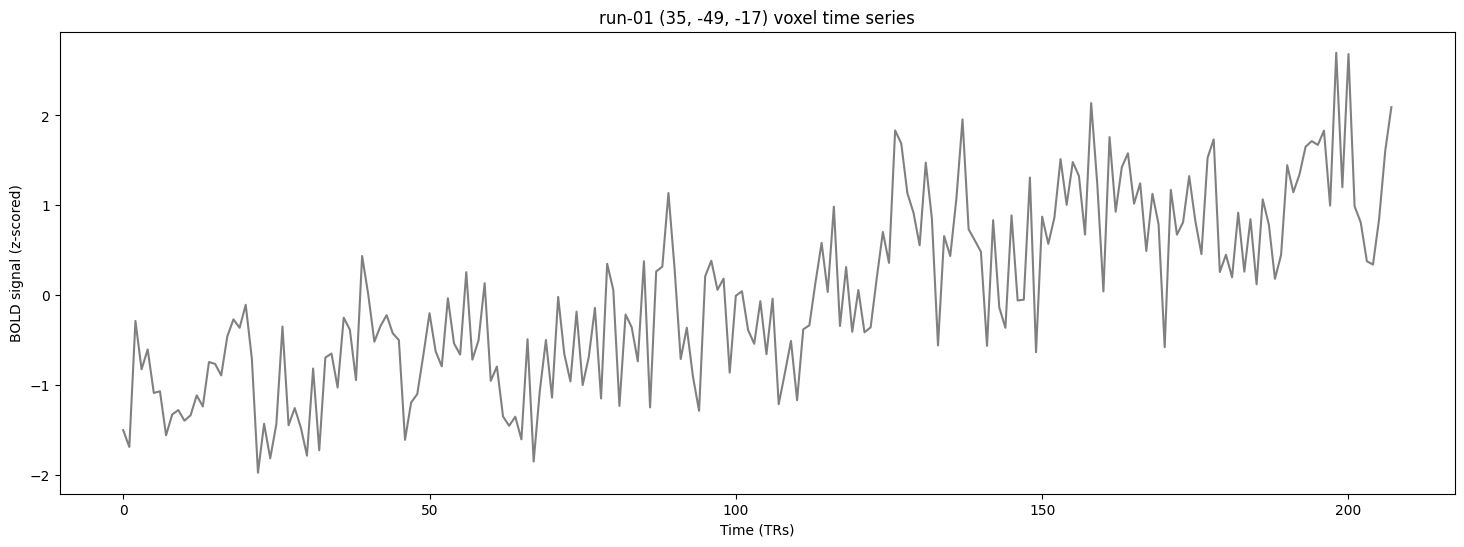

In [6]:
# voxel of interest
MNI_coord = [(35, -49, -17)] 

# get the TR
TR = layout.get_tr()

# extract the time series 
coord_masker = NiftiSpheresMasker(
  MNI_coord, 
  t_r=TR, 
  standardize='zscore'
)
coord_time_series = coord_masker.fit_transform(preproc_functional_files[0])

# plot the time series  
plt.figure(figsize=(18, 6))

plt.plot(coord_time_series, color='grey')

plt.title(f"run-01 {MNI_coord[0]} voxel time series")
plt.xlabel('Time (TRs)')
plt.ylabel('BOLD signal (z-scored)')
plt.show()


The BOLD signal in this voxel during the 7-minute functional run comes from various sources. We want to determine whether our experimental conditions (viewing Famous, Unfamiliar, or Scrambled faces) contribute to this signal, and if so, by how much. To better estimate this, we aim to regress out other potential contributors that we are not interested in, such as head movement artefacts, scanner drift, and other noise.

### Predictors (X): Events

We need to specify the events that occurred during the functional acquisitions. The event files are stored in the `data/func` folder, and again, we can use `PyBIDS` to locate them.

In [7]:
event_files = layout.get(
    subject = sID, 
    datatype = 'func', 
    suffix = 'events', 
    extension = ".tsv", 
    return_type = 'filename'
)
print('Subject''s', sID, 'event files:')
print(*event_files, sep='\n')

Subjects 15 event files:
/imaging/correia/da05/workshops/2026-CBU/notebooks/../example_data/FaceRecognition/data/sub-15/ses-mri/func/sub-15_ses-mri_task-facerecognition_run-01_events.tsv
/imaging/correia/da05/workshops/2026-CBU/notebooks/../example_data/FaceRecognition/data/sub-15/ses-mri/func/sub-15_ses-mri_task-facerecognition_run-02_events.tsv
/imaging/correia/da05/workshops/2026-CBU/notebooks/../example_data/FaceRecognition/data/sub-15/ses-mri/func/sub-15_ses-mri_task-facerecognition_run-03_events.tsv
/imaging/correia/da05/workshops/2026-CBU/notebooks/../example_data/FaceRecognition/data/sub-15/ses-mri/func/sub-15_ses-mri_task-facerecognition_run-04_events.tsv
/imaging/correia/da05/workshops/2026-CBU/notebooks/../example_data/FaceRecognition/data/sub-15/ses-mri/func/sub-15_ses-mri_task-facerecognition_run-05_events.tsv
/imaging/correia/da05/workshops/2026-CBU/notebooks/../example_data/FaceRecognition/data/sub-15/ses-mri/func/sub-15_ses-mri_task-facerecognition_run-06_events.tsv
/im

Event files contain the names of our experimental conditions, their onset times (in seconds), and their durations (in seconds). The events table will have as many rows as there are trials you want to include in the model.

In [8]:
# load and display one of the event files
events_run1 = pd.read_csv(event_files[0], sep='\t')
events_run1

,onset,duration,circle_duration,trial_type,trigger,button_pushed,response_time,stim_file
0,0.000,0.910,0.416,IniFF,5,7,1.903,func/f005.bmp
1,3.124,0.996,0.450,IniFF,5,4,1.041,func/f012.bmp
2,6.564,0.830,0.577,ImmFF,6,4,1.300,func/f012.bmp
3,9.620,0.908,0.432,IniSF,17,7,1.040,func/s007.bmp
4,12.894,0.885,0.557,IniUF,13,4,1.357,func/u003.bmp
...,...,...,...,...,...,...,...,...
88,380.126,0.914,0.563,DelUF,15,7,0.662,func/u005.bmp
89,383.250,0.896,0.441,IniUF,13,7,0.890,func/u015.bmp
90,386.423,0.818,0.510,DelUF,15,7,0.648,func/u007.bmp
91,389.480,1.000,0.478,IniUF,13,4,0.826,func/u013.bmp


There are 9 trial_types, which come from a 3x3 factorial design which crosses ***stimulus type*** (**Famous Face**, `FF`; **Unfamiliar Face**, `UF`; **Scrambled Face**, `SF`) with ***presentation*** (**Initial**, `Ini`; **Immediate Repeat**, `Imm`; **Delayed Repeat**, `Del`).

In the GLM's design matrix, we include one regressor (the same length as the time series data points) for each condition. The regressor represents the predicted BOLD response to the stimulus. The BOLD signal does not simply switch from 0 to 1 (on or off); instead, it follows a specific shape known as the **haemodynamic response function (HRF)**. The HRF models the delayed and dispersed nature of the BOLD signal in response to neural activity, typically peaking a few seconds after the stimulus and then gradually returning to baseline.

To obtain our condition's predicted BOLD response, **we convolve the onset and duration times of the condition with an HRF**. Several HRF models have been derived from research, with two of the most commonly used in typical populations being Glover's HRF and SPM's HRF.

To see how it works, let's create a regressor for the **IniFF** condition. We'll use the condition's onset and duration times from the event file and convolve them with Glover's HRF. Nilearn has a built-in function for this ([glm.first_level.compute_regressor](https://nilearn.github.io/stable/modules/generated/nilearn.glm.first_level.compute_regressor.html)), so we will use that.

Text(0.5, 1.0, 'Predicted BOLD response for the IniFF condition')

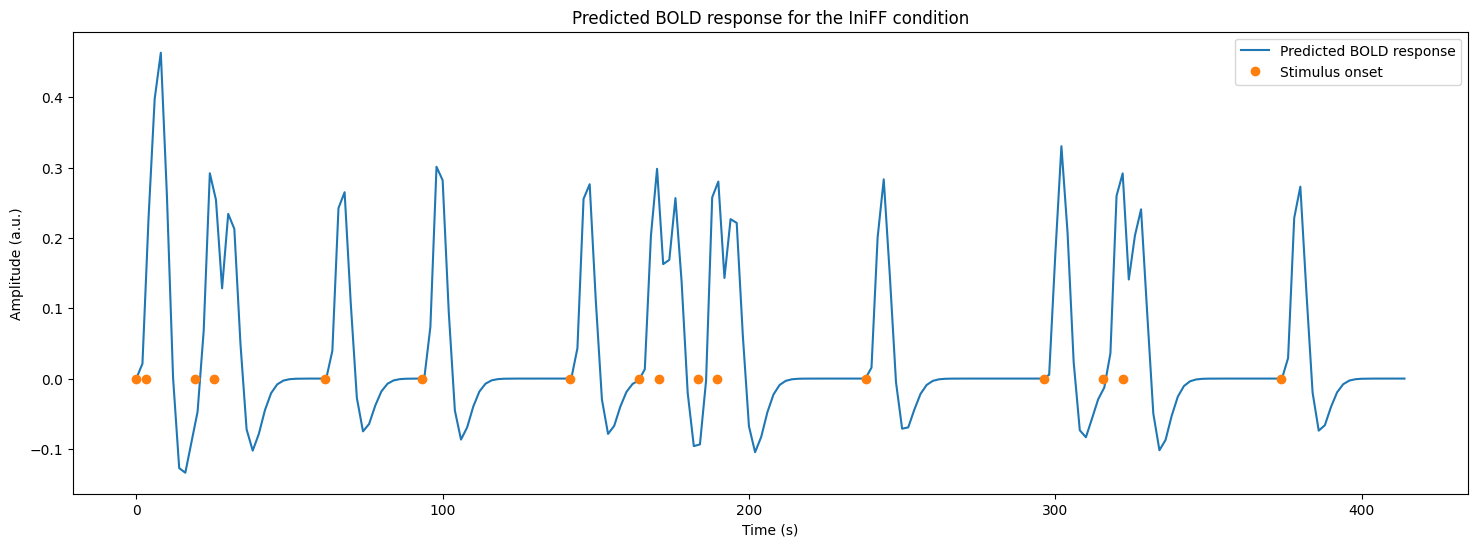

In [9]:
# Filter events_run1 DataFrame for the 'IniFF' condition
IniFF_events = events_run1[events_run1['trial_type'] == 'IniFF']

# Extract onsets and durations for the 'IniFF' condition
onsets_IniFF = IniFF_events['onset'].values
durations_IniFF = IniFF_events['duration'].values
# Set amplitudes to 1 for all events
amplitudes_IniFF = np.ones_like(onsets_IniFF)  

# Create a list of frame times (number of data points x TR, sampled every TR)
bold_image = nib.load(preproc_functional_files[0])
num_TRs = bold_image.shape[3]

frame_times = np.arange(0, num_TRs*TR, TR) 

# Create the regressor for 'IniFF' condition
regressor_IniFF, _ = compute_regressor(
  [onsets_IniFF, durations_IniFF, amplitudes_IniFF],
  hrf_model='glover', 
  frame_times=frame_times
)

# plot the regressor and also show the onsets
plt.figure(figsize=(18, 6))

plt.plot(frame_times, regressor_IniFF)
plt.plot(onsets_IniFF, np.zeros_like(onsets_IniFF), 'o')

plt.xlabel('Time (s)')
plt.ylabel('Amplitude (a.u.)')
plt.legend(['Predicted BOLD response', 'Stimulus onset'])
plt.title('Predicted BOLD response for the IniFF condition')

💡 **Note:** We created the regressor by hand above just to show what’s happening under the hood. In practice, you don’t need to manually build these regressors in Nilearn. When setting up the first-level model, you simply provide the event files, making sure they contain the *onset*, *duration*, and *trial_type* columns, and Nilearn will generate the regressors for you.

### Predictors: Confounds

Confounds represent fluctuations with a potential non-neuronal origin, such as head motion artefacts, scanner noise, and cardiac or respiratory effects. We can include them in the GLM as regressors of no interest to minimize the confounding effects of non-neuronal signals. fMRIPrep calculates a wide range of possible confounds. You can find detailed information in the [fMRIPrep documentation](https://fmriprep.org/en/stable/outputs.html#confounds).

Which confounding variables you include in the GLM depends on the analysis you want to perform. The most well-established confounds are the six head-motion parameters (three rotations and three translations). If your dataset includes physiological recordings (e.g., heart rate, respiration), you might consider including these as confounds. If not, you might include PCA components from CompCor, a method implemented in fMRIPrep that identifies noise components from CSF and white matter signals. **However, please read the fMRIPrep documentation on confounds carefully before including any additional confounds, and never include all confounds in the GLM design matrix!**

If your study has specific considerations (e.g., participant behaviour or task-related noise), you may need to include additional custom confounds.

The confounds computed by `fMRIPrep` can be found in the `data/derivatives/fmriprep/{sub}/func/` directory. They are stored separately for each run in `.tsv` files, with one column for each confound variable. Let's use `PyBIDS` to locate these files.

In [10]:
confound_files = layout.get(
    subject = sID, 
    datatype = 'func', 
    desc = 'confounds', 
    extension = ".tsv", 
    return_type = 'filename'
)

print('Subject''s', sID, 'confound files:')
print(*confound_files, sep='\n')

Subjects 15 confound files:
/imaging/correia/da05/workshops/2026-CBU/notebooks/../example_data/FaceRecognition/data/derivatives/fmriprep/sub-15/ses-mri/func/sub-15_ses-mri_task-facerecognition_run-01_desc-confounds_timeseries.tsv
/imaging/correia/da05/workshops/2026-CBU/notebooks/../example_data/FaceRecognition/data/derivatives/fmriprep/sub-15/ses-mri/func/sub-15_ses-mri_task-facerecognition_run-02_desc-confounds_timeseries.tsv
/imaging/correia/da05/workshops/2026-CBU/notebooks/../example_data/FaceRecognition/data/derivatives/fmriprep/sub-15/ses-mri/func/sub-15_ses-mri_task-facerecognition_run-03_desc-confounds_timeseries.tsv
/imaging/correia/da05/workshops/2026-CBU/notebooks/../example_data/FaceRecognition/data/derivatives/fmriprep/sub-15/ses-mri/func/sub-15_ses-mri_task-facerecognition_run-04_desc-confounds_timeseries.tsv
/imaging/correia/da05/workshops/2026-CBU/notebooks/../example_data/FaceRecognition/data/derivatives/fmriprep/sub-15/ses-mri/func/sub-15_ses-mri_task-facerecognition

Let's get a list of all confounds of the first functional run. 

In [11]:
confounds_run1 = pd.read_table(confound_files[0])

print('Number of confounds in run 1:', len(list(confounds_run1)))
print('Number of data points for ech confound:', len(confounds_run1), '\n')
#print(*list(confounds_run1), sep='\n')
confounds_run1


Number of confounds in run 1: 212
Number of data points for ech confound: 208 



,global_signal,global_signal_derivative1,global_signal_power2,global_signal_derivative1_power2,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,...,rot_x_derivative1_power2,rot_x_power2,rot_y,rot_y_derivative1,rot_y_power2,rot_y_derivative1_power2,rot_z,rot_z_derivative1,rot_z_derivative1_power2,rot_z_power2
0,795.294277,NaN,632492.987683,NaN,1205.429348,NaN,1.453060e+06,NaN,713.524504,NaN,...,NaN,2.634625e-07,0.000030,NaN,9.135264e-10,NaN,0.000274,NaN,NaN,7.511930e-08
1,795.132733,-0.161544,632236.063633,0.026096,1199.808957,-5.620391,1.439542e+06,31.588796,714.462834,0.938330,...,4.066613e-11,2.569567e-07,-0.000389,-0.000419,1.513506e-07,1.757811e-07,0.000292,0.000018,3.256942e-10,8.533760e-08
2,793.456792,-1.675941,629573.680544,2.808780,1197.333036,-2.475921,1.433606e+06,6.130184,714.561069,0.098235,...,1.132500e-08,1.603922e-07,-0.000172,0.000217,2.971038e-08,4.694632e-08,0.000217,-0.000075,5.641512e-09,4.709594e-08
3,796.667041,3.210249,634678.373906,10.305698,1196.994656,-0.338380,1.432796e+06,0.114501,715.046148,0.485079,...,7.571798e-08,4.565151e-07,-0.000158,0.000014,2.496147e-08,2.066406e-10,0.000326,0.000109,1.185769e-08,1.062167e-07
4,795.187114,-1.479927,632322.545623,2.190185,1196.450486,-0.544169,1.431494e+06,0.296120,715.348226,0.302078,...,4.465149e-08,2.156209e-07,-0.000370,-0.000212,1.369518e-07,4.497708e-08,0.000315,-0.000011,1.118095e-10,9.943616e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,797.227925,-0.858045,635572.363939,0.736241,1204.901344,-1.628502,1.451787e+06,2.652019,719.121296,-0.434643,...,1.575614e-09,4.996723e-07,0.000074,0.000039,5.412913e-09,1.504315e-09,-0.003469,0.000310,9.633574e-08,1.203639e-05
204,796.091964,-1.135961,633762.415055,1.290407,1204.338580,-0.562764,1.450431e+06,0.316704,718.574736,-0.546560,...,8.611376e-07,2.672735e-06,0.000394,0.000320,1.552525e-07,1.026872e-07,-0.003653,-0.000183,3.354759e-08,1.334083e-05
205,795.548132,-0.543831,632896.831110,0.295753,1204.550860,0.212280,1.450943e+06,0.045063,719.208489,0.633752,...,2.215773e-07,1.355199e-06,0.000009,-0.000385,8.146236e-11,1.482214e-07,-0.003623,0.000030,8.832784e-10,1.312461e-05
206,795.597366,0.049234,632975.169127,0.002424,1204.534790,-0.016069,1.450904e+06,0.000258,718.657825,-0.550663,...,3.665176e-07,3.121714e-07,-0.000248,-0.000257,6.156850e-08,6.612903e-08,-0.003331,0.000292,8.500140e-08,1.109716e-05


In this example, we will include only the most commonly used confounds—the **six motion parameters**.

In [12]:
confounds_of_interest = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']

Let's display the confounds of interest of the first run.

In [13]:
confounds_run1[confounds_of_interest]

,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
0,-0.047662,-0.048473,0.018206,-0.000513,0.000030,0.000274
1,-0.048418,-0.058472,0.022559,-0.000507,-0.000389,0.000292
2,-0.061884,-0.027687,-0.006128,-0.000400,-0.000172,0.000217
3,-0.048395,-0.018090,0.023410,-0.000676,-0.000158,0.000326
4,-0.048402,-0.048456,0.011915,-0.000464,-0.000370,0.000315
...,...,...,...,...,...,...
203,-0.011507,-0.085456,-0.351604,0.000707,0.000074,-0.003469
204,-0.011393,-0.074199,-0.379033,0.001635,0.000394,-0.003653
205,-0.001416,-0.111968,-0.382017,0.001164,0.000009,-0.003623
206,0.007821,-0.062986,-0.364801,0.000559,-0.000248,-0.003331


Out of interest, we can use the `fit_transform` function again, which we previously used to extract an example voxel's time series, but this time, we'll include the confounds to regress them out from the data.

In [14]:
## This we used to extact the original time series:
# coord_masker = NiftiSpheresMasker(
#     MNI_coord, t_r=TR, standardize='zscore'
# )
# coord_time_series = coord_masker.fit_transform(preproc_functional_files[0])

# Now we will extract the time series with the confounds of interest regressed out
coord_time_series_no_confounds = coord_masker.fit_transform(
  preproc_functional_files[0], 
  confounds = confounds_run1[confounds_of_interest]
  )


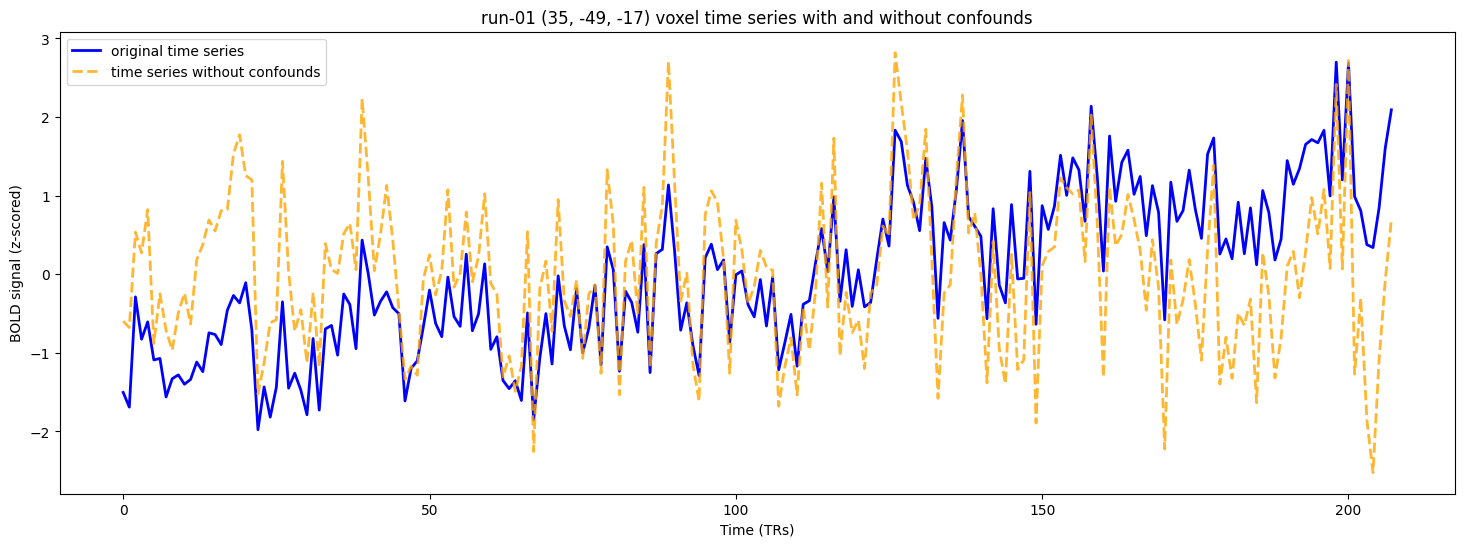

In [15]:
# plot the time series with and without confounds
plt.figure(figsize=(18, 6))

plt.plot(coord_time_series, label='original time series', color='blue', linewidth=2)
plt.plot(coord_time_series_no_confounds, label='time series without confounds', color='orange', linestyle='--', linewidth=2, alpha=0.8)

plt.title(f"run-01 {MNI_coord[0]} voxel time series with and without confounds")
plt.xlabel('Time (TRs)')
plt.ylabel('BOLD signal (z-scored)')
plt.legend()
plt.show()

We need to select the confounds of interest from the other eight runs as well. We will include the confounds of interest from each run in our GLM model by creating a list of confound tables.

In [16]:
confounds_for_glm = []
for conf_file in confound_files:
    this_conf = pd.read_table(conf_file)
    conf_subset = this_conf[confounds_of_interest].fillna(0) # replace NaN with 0
    confounds_for_glm.append(conf_subset)

## Performing the GLM analysis

We now have everything we need for this subject: the BOLD images, event files, and confound regressors for each of the 9 functional runs. Nilearn can use these together to **fit a first-level GLM** and compute fixed-effects statistics (i.e., effects averaged across runs within this subject).

To do this, we will create a `FirstLevelModel` object. Based on the inputs we provide (BOLD images, event files, TR, confounds, etc.), it will automatically build the design matrix and estimate the model for us.

### Creating the First Level Model

Now we can specify the model with the parameters of our choice (see the [documentation](https://nilearn.github.io/stable/modules/generated/nilearn.glm.first_level.FirstLevelModel.html) for a full list of parameters). Here we will specify the folowing:
* **t_r** - repetition time (the sampling interval of the functional runs) in seconds. We can get it from our BIDS layout.

* **slice_time_ref**: *This parameter indicates the time of the reference slice used in the slice timing preprocessing step of the experimental runs. It is expressed as a percentage of the t_r (time repetition), so it can have values between 0. and 1. Default=0.* 
  
  We can find this information in our fMRIPrep Methods (*data/derivatives/fmriprep/logs/CITATION.html*). There we read: *"BOLD runs were slice-time corrected to 0.974s (0.5 of slice acquisition range 0s-1.95s)"*. This means, that **0.5** is the value we need to use for this parameter. 
  
  Alternativel, and perhaps preferably, we can obtain this information from the BIDS derivatives metadata. It also tells if the slice-time correction was performed at all. 

  `data/derivatives/fmriprep/sub-15/ses-mri/func/sub-15_ses-mri_task-facerecognition_run-01_space-MNI152NLin6Asym_res-2_desc-preproc_bold.json`
  ```json
    {
      "RepetitionTime": 2,
      "SkullStripped": false,
      "SliceTimingCorrected": true,
      "StartTime": 0.974,
      "TaskName": "facerecognition"
    }
```

The metadata indicates that slice-time correction was applied, and the start time was adjusted from 0 to 0.974—representing the middle of the acquisition range.

In [17]:
# If slice timing correction was applied, get the slice time reference
slice_timing = layout.get_metadata(preproc_functional_files[0])
if slice_timing['SliceTimingCorrected']:
  slice_time_ref = slice_timing['StartTime'] / TR
  print('Slice timing reference:', slice_time_ref)
else:
  slice_time_ref = 0
  print('Slice timing correction was not applied')

Slice timing reference: 0.487


* **hrf_model**: defines the HRF model to be used. Possible options:
  * `spm`: This is the HRF model used in SPM. 
  * `spm + derivative`: SPM model plus its time derivative. This gives 2 regressors.
  * `spm + derivative + dispersion`: Idem, plus dispersion derivative. This gives 3 regressors.
  * `glover`: This corresponds to the Glover HRF.
  * `glover + derivative`: The Glover HRF + time derivative. This gives 2 regressors. 
  * `glover + derivative + dispersion`: Idem, plus dispersion derivative. This gives 3 regressors. 
  * `fir`: Finite impulse response basis. This is a set of delayed dirac models.

It can also be a custom model. In this case, a function should be provided for each regressor.
  
The choice of the HRF model is up to the user. There's little difference between using the SPM or Glover model.  **In general, it is advisable to include temporal and dispersion derivatives to allow for variability across individuals and brain regions. However, you should only include these derivatives in designs that are efficient for estimating the HRF shape, i.e, have long times (~6+ secs) between trials, or jittered times between trials (e.g., 2-20 secs, often by virtue of randomly intermixing "null events"); for short stimulus-onset-asynchronies (SOAs) of ~2 secs between trials (with no null events), one cannot distinguish a delayed response to one trial (fit by the temporal derivative of the HRF) from a reduced amplitude on the subsequent trial.**

Let's see how, for example, SPM and Glover HRFs compare.

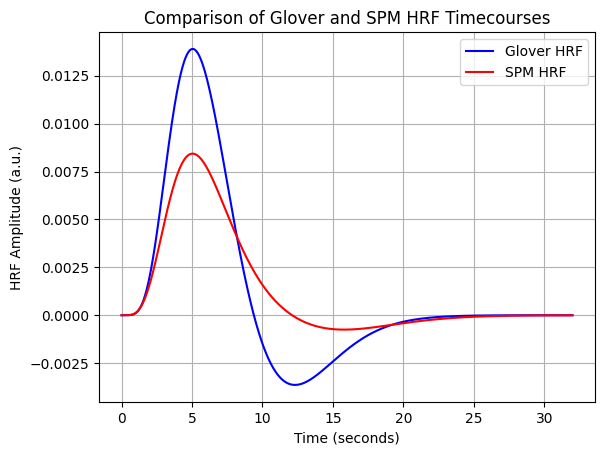

In [18]:
# modeled time in seconds
time_length = 32

# Generate the HRF timecourses
glover_timecourse = glover_hrf(TR, time_length=time_length)
spm_timecourse = spm_hrf(TR, time_length=time_length)

# Plot the timecourses
timepoints = np.linspace(0, time_length, num=len(glover_timecourse))
plt.plot(timepoints, glover_timecourse, label='Glover HRF', color='blue')
plt.plot(timepoints, spm_timecourse, label='SPM HRF', color='red')
plt.title('Comparison of Glover and SPM HRF Timecourses')
plt.xlabel('Time (seconds)')
plt.ylabel('HRF Amplitude (a.u.)')
plt.legend()
plt.grid(True)
plt.show()

* **drift_model**: Specifies the desired drift model for the design matrices. It can be '*polynomial*', '*cosine*', or *None*. The default is '*cosine*'. Additional nuisance regressors are added to the design matrix to account for low-frequency noise (such as scanner drift or physiological fluctuations) that are unlikely to come from the experimental conditions. 
* **high_pass**: Used only if drift_model is *'cosine'*. Default is 0.01 Hz (1/128 Hz). It defines the cutoff frequency for the cosine drift model, and cosine functions with frequencies lower than this threshold are added as drift regressors. This ensures that only higher-frequency components, typically associated with neural activity, remain unmodeled in the design matrix.
* **smoothing_fwhm**: the full-width at half maximum in millimeters of the spatial smoothing to apply to the signal (smoothing was not done in fMRIPrep!).
* **noise_model**: {‘ar1’, ‘ols’} The temporal variance model. Default=’ar1’.
* **mask_img**: path_to_mask_image, # default is None and Nilearn will compute it. We will include here the subject's anatomical brain mask created by fMRIPrep. 

In [19]:
# --- Get the brain mask
brain_mask = layout.get(
    subject=sID, 
    datatype='anat', 
    suffix='mask', 
    desc='brain', 
    space="MNI152NLin6Asym", 
    extension='.nii.gz',
    return_type='filename'
    )
print("Brain mask file", brain_mask[0])

Brain mask file /imaging/correia/da05/workshops/2026-CBU/notebooks/../example_data/FaceRecognition/data/derivatives/fmriprep/sub-15/ses-mri/anat/sub-15_ses-mri_space-MNI152NLin6Asym_res-9_desc-brain_mask.nii.gz


Our first-level model:

In [20]:
first_level_model = FirstLevelModel(
    t_r = TR,
    slice_time_ref = slice_time_ref,
    smoothing_fwhm = 6, # a rule of thumb is 3x the voxel size
    hrf_model = 'SPM',  # (to better relate to analysis of these data using SPM12)
    drift_model = 'cosine', # default
    high_pass = 0.01, # default; Used only if drift_model is ‘cosine’ to set its cutoff frequency
    noise_model = 'ar1', # default
    mask_img = brain_mask[0],
    n_jobs = 2 # use two CPUs for computation
)

### Fitting the model

Now that we have specified the model, we can run it on our data. We need to include the list of our functional image files, the list of event timing files, and the list of our confound tables (one per run).

In [21]:
# Fit the first-level model
first_level_model = first_level_model.fit(
  preproc_functional_files, 
  event_files, 
  confounds_for_glm
  )

/tmp/ipykernel_2985591/205460931.py:2: UserWarning: [NiftiMasker.fit] Generation of a mask has been requested (imgs != None) while a mask was given at masker creation. Given mask will be used.
  first_level_model = first_level_model.fit(
/tmp/ipykernel_2985591/205460931.py:2: UserWarning: The following unexpected columns in events data will be ignored: circle_duration, button_pushed, trigger, stim_file, response_time
  first_level_model = first_level_model.fit(
/tmp/ipykernel_2985591/205460931.py:2: UserWarning: The following unexpected columns in events data will be ignored: circle_duration, button_pushed, trigger, stim_file, response_time
  first_level_model = first_level_model.fit(
/tmp/ipykernel_2985591/205460931.py:2: UserWarning: The following unexpected columns in events data will be ignored: circle_duration, button_pushed, trigger, stim_file, response_time
  first_level_model = first_level_model.fit(
/tmp/ipykernel_2985591/205460931.py:2: UserWarning: The following unexpected c

### Inspecting the Design Matrix

We can now inspect the design matrix of our GLM model (rows represent time, and columns contain the predictors).

The `design_matrices` is a list of 9 tables (one per run). Let's look at the first run's design matrix.

Design matrix for run 1


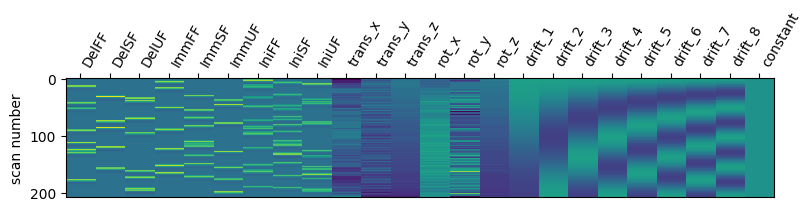

In [22]:
# get the design matrices from the glm model
design_matrices = first_level_model.design_matrices_

print('Design matrix for run', 1)
plot_design_matrix(design_matrices[0], output_file=None)

fig = plt.gcf()
fig.set_size_inches(8,2)
plt.show()

Let’s also take a look at the data included in the design matrix.

In [23]:
# display the design matrix of the first run
design_matrices[0]

,DelFF,DelSF,DelUF,ImmFF,ImmSF,ImmUF,IniFF,IniSF,IniUF,trans_x,...,rot_z,drift_1,drift_2,drift_3,drift_4,drift_5,drift_6,drift_7,drift_8,constant
0.974,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000520,0.000000,0.000000,-0.047662,...,0.000274,0.098055,0.098047,0.098033,0.098013,0.097988,0.097957,0.097921,0.097879,1.0
2.974,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.073150,0.000000,0.000000,-0.048418,...,0.000292,0.098033,0.097957,0.097832,0.097656,0.097430,0.097153,0.096828,0.096452,1.0
4.974,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.199902,0.000000,0.000000,-0.061884,...,0.000217,0.097988,0.097779,0.097430,0.096942,0.096316,0.095552,0.094653,0.093618,1.0
6.974,0.0,0.0,0.000000,0.000004,0.0,0.000000,0.305605,0.000000,0.000000,-0.048395,...,0.000326,0.097921,0.097511,0.096828,0.095874,0.094653,0.093167,0.091421,0.089419,1.0
8.974,0.0,0.0,0.000000,0.035488,0.0,0.000000,0.288458,0.000000,0.000000,-0.048402,...,0.000315,0.097832,0.097153,0.096027,0.094456,0.092450,0.090017,0.087168,0.083916,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406.974,0.0,0.0,-0.009032,0.000000,0.0,-0.013115,0.000000,-0.000221,-0.021126,-0.011507,...,-0.003469,-0.097832,0.097153,-0.096027,0.094456,-0.092450,0.090017,-0.087168,0.083916,1.0
408.974,0.0,0.0,-0.004923,0.000000,0.0,-0.017962,0.000000,-0.000074,-0.014616,-0.011393,...,-0.003653,-0.097921,0.097511,-0.096828,0.095874,-0.094653,0.093167,-0.091421,0.089419,1.0
410.974,0.0,0.0,-0.002394,0.000000,0.0,-0.015566,0.000000,0.000000,-0.008652,-0.001416,...,-0.003623,-0.097988,0.097779,-0.097430,0.096942,-0.096316,0.095552,-0.094653,0.093618,1.0
412.974,0.0,0.0,-0.001004,0.000000,0.0,-0.010685,0.000000,0.000000,-0.004506,0.007821,...,-0.003331,-0.098033,0.097957,-0.097832,0.097656,-0.097430,0.097153,-0.096828,0.096452,1.0


You may notice that the values for IniFF are somewhat different from the values in the event regressor `regressor_IniFF` that we calculated earlier (evaluate `regressor_IniFF[0:5]`). This is because the onset time of the events is not 0, but 0.974. This is the shift of half a TR to match the slice-timing.

In [24]:
df_combined = pd.DataFrame({
  'IniFF before slice-timing': regressor_IniFF[0:5].flatten(),
  'IniFF after slice-timing': design_matrices[0]['IniFF'].head(5).values
})

print(df_combined)

   IniFF before slice-timing  IniFF after slice-timing
0                   0.000000                  0.000520
1                   0.021076                  0.073150
2                   0.228695                  0.199902
3                   0.397791                  0.305605
4                   0.463249                  0.288458


In the design matrix, we can observe several drift regressors. These are generated from the `drift_model` ('*cosine*') that we specified for our GLM model, capturing frequencies lower than the threshold set by the `high_pass` parameter. These regressors account for slow oscillations, which are unlikely to arise from our experimental conditions.

Now, let's plot the event regressors alongside the low-frequency drift regressors to better visualise these concepts.

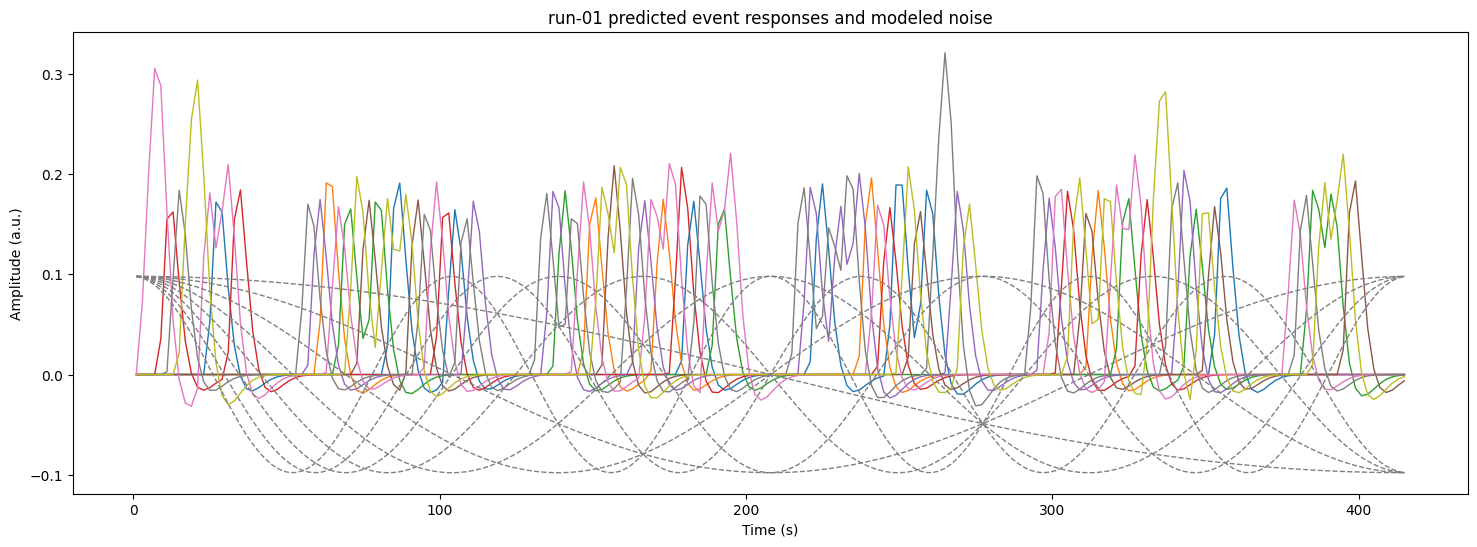

In [25]:
dm = design_matrices[0]
event_regressors = dm.columns[:9]
drift_regressors = [col for col in dm.columns if col.startswith('drift_')]

plt.figure(figsize=(18, 6))

# Plot the predicted event responses
for event in event_regressors:
    plt.plot(dm.index, dm[event], lw=1)

# Plot the modeled noise
for drift in drift_regressors:
    plt.plot(dm.index, dm[drift], color='grey', lw=1, linestyle='--')
    
plt.title('run-01 predicted event responses and modeled noise')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (a.u.)')

plt.show()


We can see how the low-frequency drifts differ in shape and timing from the event-related signals. This helps illustrate how the GLM separates task-related neural activity from unrelated noise.

Ideally, the event regressors should not overlap much with the drift regressors. It's not a problem in our event-relighted design, but could be more problematic in slow block-designs. Significant overlap could suggest that some task-related variance is being captured by the noise model, reducing the sensitivity to detect neural signals.

Now, let's use the `fit_transform` function on our original example voxel's time series data. We will fit the nuisance regressors (motion and drift parameters) to the time series to remove the variance associated with these noise sources from the data.

We will plot this denoised time series against our predicted event responses. This will help visualise how well the model fits the data after accounting for nuisance factors. It provides an indication of how accurately the GLM captures the relationship between the experimental conditions and brain activity. A strong correspondence between the predicted responses and the denoised time series would suggest that the beta estimates are capturing meaningful signals related to the experimental conditions.

In [26]:
nuiseance_regressors = design_matrices[0].columns[9:-1]
print('Nuisance regressors:', nuiseance_regressors)

# extract the time series with the nuiseance regressors regressed out                                                                   
coord_time_series_denoised = coord_masker.fit_transform(
  preproc_functional_files[0], 
  confounds = design_matrices[0][nuiseance_regressors]
  )

Nuisance regressors: Index(['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'drift_1',
       'drift_2', 'drift_3', 'drift_4', 'drift_5', 'drift_6', 'drift_7',
       'drift_8'],
      dtype='object')


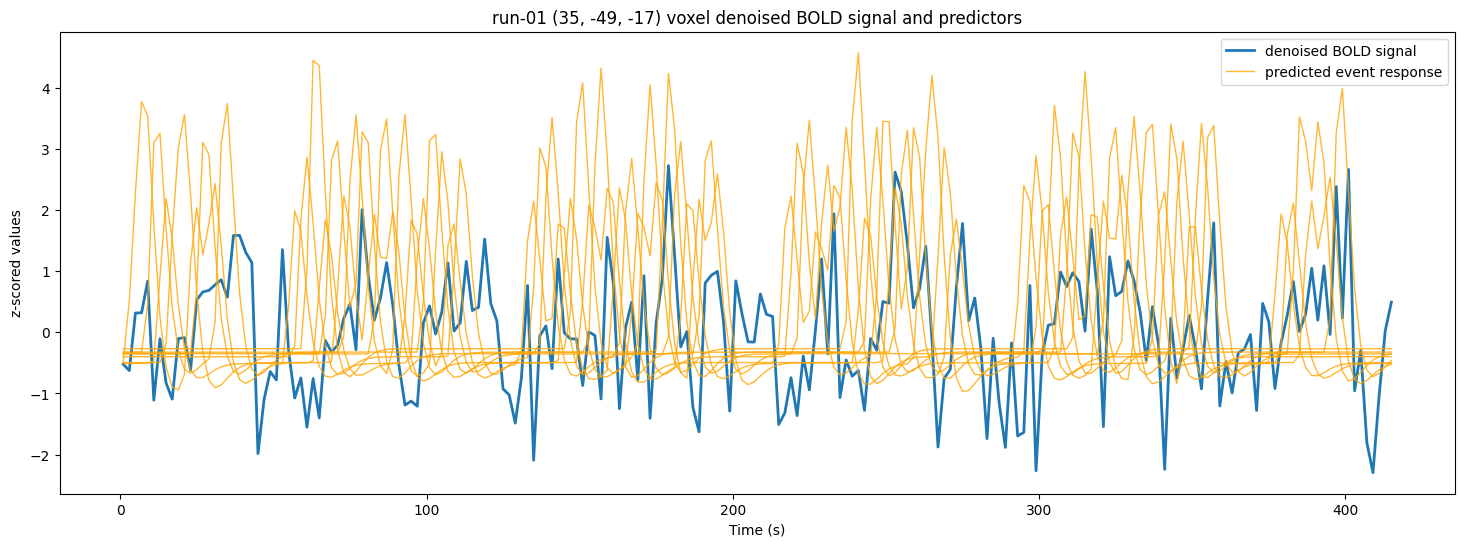

In [27]:
# plot the regressors along the bold time series
plt.figure(figsize=(18, 6))

plt.plot(dm.index, coord_time_series_denoised, label='denoised BOLD signal', linewidth=2)

# Plot the predicted event responses
for event in event_regressors:
    zscored_event = (dm[event] - dm[event].mean()) / dm[event].std()
    plt.plot(dm.index, zscored_event, 
             color='orange', lw=1, alpha=0.8)
    
plt.plot([],[], label="predicted event response", color='orange', lw=1, alpha=0.8)

plt.title(f"run-01 {MNI_coord[0]} voxel denoised BOLD signal and predictors")
plt.xlabel('Time (s)')
plt.ylabel('z-scored values')
plt.legend()

To obtain the actual beta estimates, we need to specify contrasts.

## Contrast specification

A contrast is a linear combination of the beta estimates that allows us to test specific hypotheses about the experimental conditions. Each condition or regressor in the model is assigned a weight in the contrast, and these weights are combined to produce a contrast estimate.

For example, to **compare two conditions** and test whether the mean activation in Condition A is greater than in Condition B, the contrast vector would be `c = [1, -1, 0, ...]`. Here, the 1 corresponds to Condition A, and the -1 corresponds to Condition B, indicating that we are comparing the two conditions. Zeros correspond to other conditions or regressors that are not part of the contrast. The resulting contrast estimate tests the difference between the beta estimates for these two conditions.

You can also test **combinations of conditions** by assigning equal weights to multiple conditions. For example, to test whether the mean activation across two conditions (A and B) is greater than that in a third condition (C), the contrast vector would be `[0.5, 0.5, -1, 0, ...]`. This reflects an average of Conditions A and B compared to Condition C.

If you are interested in testing **the effect of a single condition** against the baseline, the contrast would be `[1, 0, 0, ...]`, where the 1 refers to the condition of interest, and the zeros correspond to other conditions or regressors that are not part of the contrast.

An **effects of interest** contrast is often used to assess the overall impact of all conditions or predictors of interest in the model. For effects of interest, a matrix-type contrast is used. This allows testing whether all conditions of interest, taken together, explain a significant amount of variance in the data. For example, if you have three conditions (A, B, C) and want to test whether they collectively explain significant variance, your matrix-type contrast would be:

 $c = \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \end{bmatrix}$

 This type of contrast is commonly used in omnibus tests to determine whether any of the conditions have an effect, similar to an ANOVA in traditional statistics.


### A simple case contrast

In [28]:
# Display all columns to know how to set up the contrasts
design_matrices[0].head(0)

,DelFF,DelSF,DelUF,ImmFF,ImmSF,ImmUF,IniFF,IniSF,IniUF,trans_x,...,rot_z,drift_1,drift_2,drift_3,drift_4,drift_5,drift_6,drift_7,drift_8,constant


A contrast must have the same length as the number of predictors in the design matrix.

In [29]:
# A simple case contrast

n_columns = design_matrices[0].shape[1]  # Number of predictors in the model
n_conditions = len(events_run1['trial_type'].unique())  # Number of unique conditions

contrasts = {
    'Faces_Scrambled': np.pad([1, -2, 1, 1, -2, 1, 1, -2, 1], (0, n_columns - n_conditions), 'constant'),
    'Famous_Unfamiliar': np.pad([1, 0, -1, 1, 0, -1, 1, 0, -1], (0, n_columns - n_conditions), 'constant'),
    'EffectsOfInterest': np.eye(n_columns)[:n_conditions]  
}


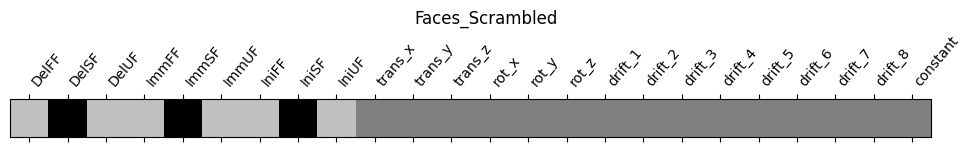

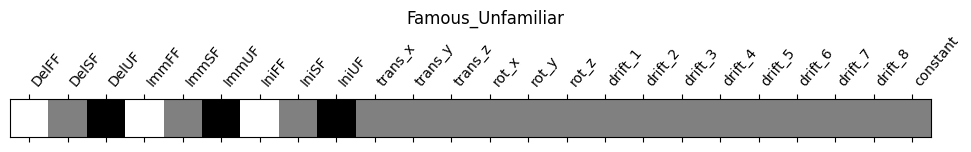

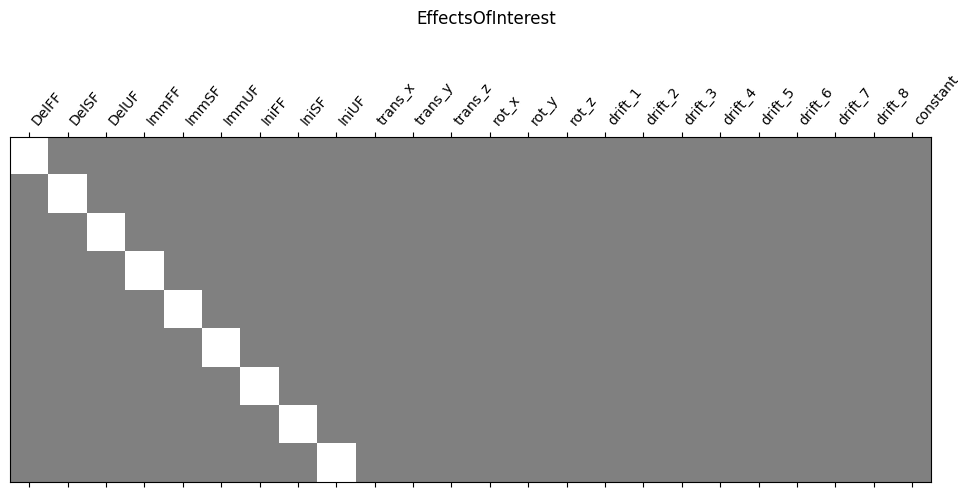

In [30]:
# display the contrasts
for key, values in contrasts.items():
  plot_contrast_matrix(values, design_matrix=design_matrices[0], colorbar=False)
  plt.suptitle(key)

plt.show()

### Contrast scaling

As mentioned earlier, a GLM contrast is a linear combination of predictor beta coefficients (parameter estimates), where each beta represents the weight or contribution of a given predictor to the overall model.

For example, if we have conditions (predictors): Famous, Unfamiliar, and Scrambled, a contrast estimating Faces vs. Scrambled with weights `[1, 1, -2]` would calculate Famous + Unfamiliar - 2 * Scrambled. This can be interpreted as the sum of the responses to Famous and Unfamiliar faces, minus twice the response to Scrambled faces. However, what we typically want is the average response to Famous and Unfamiliar faces minus the response to Scrambled faces. To achieve this, we would need to scale the contrast as follows: `[0.5, 0.5, -1]`.

Scaling contrast weights affects the magnitude of the resulting contrast estimate, but not the t-values or p-values, so the statistical inference remains unchanged. However, contrast estimates that reflect averages rather than sums are generally more meaningful for interpretation.

Finally, note that if different runs contain different numbers of trials per condition, you can also weight the contrast by the relative number of trials in each run. This way, runs with more data contribute more strongly, producing an estimate equivalent to what you’d get if all runs were concatenated (see [Rik's Stats tutorial](https://github.com/RikHenson/Stats4Imaging) for more information).

In [31]:
# A contrast scaling function, which scales for the number of conditions and runs

def scale_contrast(contrast_vector, nruns):
    positive_sum = np.sum(contrast_vector[contrast_vector > 0])  # Sum of positive weights
    negative_sum = np.abs(np.sum(contrast_vector[contrast_vector < 0]))  # Sum of negative weights (absolute)
    
    # Scale each part of the vector separately
    scaled_vector = np.zeros_like(contrast_vector, dtype=float)
    scaled_vector[contrast_vector > 0] = contrast_vector[contrast_vector > 0] / (positive_sum * nruns)
    scaled_vector[contrast_vector < 0] = contrast_vector[contrast_vector < 0] / (negative_sum * nruns)
    
    return scaled_vector

In [32]:
example_contrast = np.array([-1, -1, -1, -1, -1, -1, 2, 2, 2]) # Initial > Repeats
print('\n Original contrast:\n', example_contrast)
print('\n Scaled contrast for one run:\n', scale_contrast(example_contrast, 1))
print('\n Scaled contrast for nine runs:\n', scale_contrast(example_contrast, n_conditions))


 Original contrast:
 [-1 -1 -1 -1 -1 -1  2  2  2]

 Scaled contrast for one run:
 [-0.16666667 -0.16666667 -0.16666667 -0.16666667 -0.16666667 -0.16666667
  0.33333333  0.33333333  0.33333333]

 Scaled contrast for nine runs:
 [-0.01851852 -0.01851852 -0.01851852 -0.01851852 -0.01851852 -0.01851852
  0.03703704  0.03703704  0.03703704]


### The final contrasts for our model

In our model, we have 9 runs. If each run has the same set of regressors in the same order, then we only need to specify a contrast once and Nilearn will automatically apply it across all runs.

However, to be safe (and to avoid unexpected errors if the design matrices differ even slightly), it is good practice to **explicitly define the contrast for each run**. This ensures that each contrast is matched correctly to the regressors in that run.

#### Scaled contrasts for comparing conditions

In [33]:
nruns = len(design_matrices)  # Number of runs

comparison_contrast_list = []

for design_matrix in design_matrices:
  n_columns = design_matrix.shape[1]  # number of predictors

  # Define the contrasts and scale them
  contrasts = {
      'Faces_Scrambled': scale_contrast(np.pad([1, -2, 1, 1, -2, 1, 1, -2, 1], (0, n_columns - n_conditions), 'constant'), nruns),
      'Famous_Unfamiliar': scale_contrast(np.pad([1, 0, -1, 1, 0, -1, 1, 0, -1], (0, n_columns - n_conditions), 'constant'), nruns),
      'EffectsOfInterest': np.eye(n_columns)[:n_conditions]  # No scaling needed here
      }
  
  comparison_contrast_list.append(contrasts)

len(comparison_contrast_list) # Should be one per run

9

#### Scaled contrasts for each condition of interest

Single-condition contrasts (but averaged accross runs) are useful for obtaining condition-specific beta estimates for further analysis. For example, in [group-level analysis](nb05_Group-Level-Analysis.ipynb), subject-level single-condition contrasts allow for more flexibility in combining or comparing conditions at the group level. Additionally, for [region-of interest (ROI) analysis](nb06_ROI_analysis.ipynb), single-condition beta estimates are often necessary to assess the specific effects of each condition within a defined region.

In [34]:
# Create contrasts for all unique conditions
events_df = pd.read_table(event_files[0])
unique_conditions = events_df['trial_type'].unique()
# sort the conditions (don't neccessarily need to sort them)
unique_conditions.sort() 

basic_contrast_list = [] # we will append these to the condition-comparing contrasts created above

for design_matrix in design_matrices:
    n_columns = design_matrix.shape[1]  # number of predictors
    column_names = design_matrix.columns  # get the names of the columns
    
    # Create an empty dictionary to store contrasts for all conditions
    contrasts = {}
    
    for condition in unique_conditions:
        # Initialize the contrast vector with zeros
        contrast_vector = np.zeros(n_columns)
        
        # Assign 1 to the columns that correspond to the current condition
        for i, col_name in enumerate(column_names):
            if col_name.startswith(condition):
                contrast_vector[i] = 1/nruns # Scale the contrast for the number of runs
        
        # Store the contrast for the current condition
        contrasts[condition] = contrast_vector    
    
    # Append all contrasts for this design matrix
    basic_contrast_list.append(contrasts)
    
len(basic_contrast_list) # Should be one per run

9

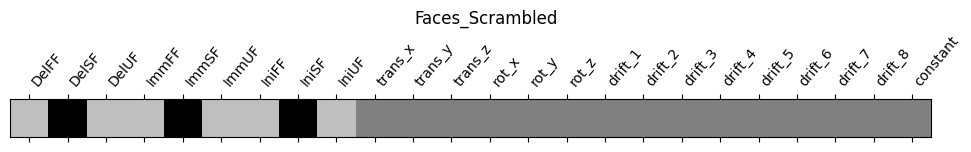

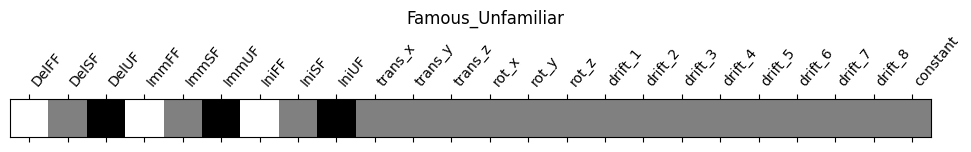

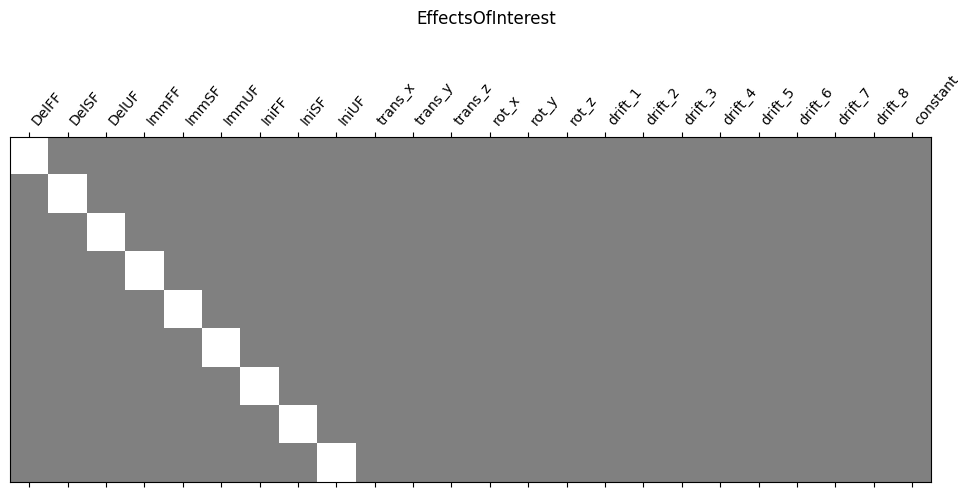

In [35]:
for key, values in comparison_contrast_list[0].items():
    plot_contrast_matrix(values, design_matrix=design_matrices[0], colorbar=False)
    plt.suptitle(key)

plt.show()

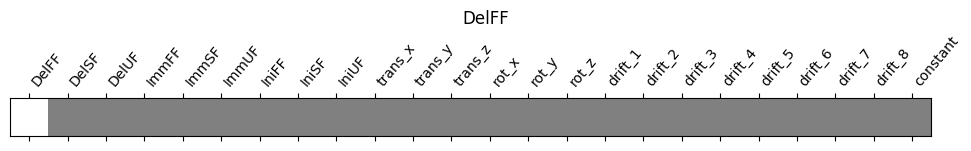

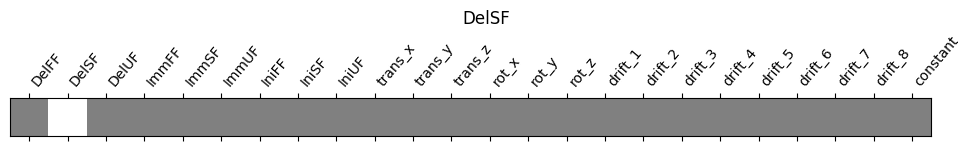

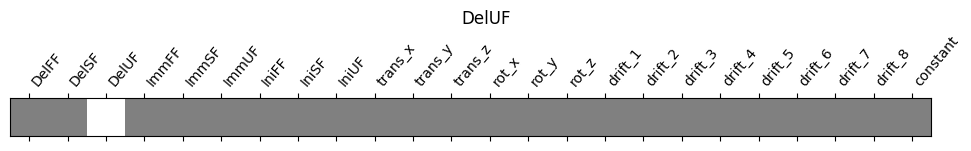

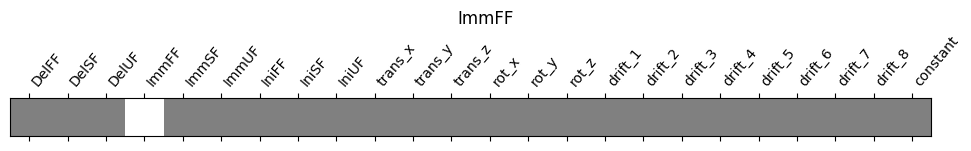

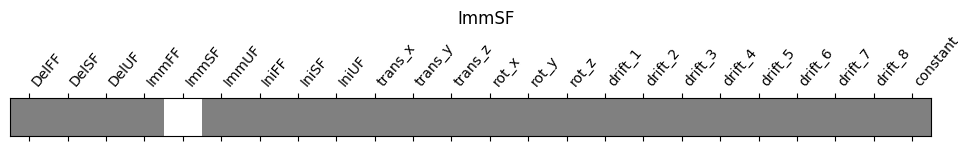

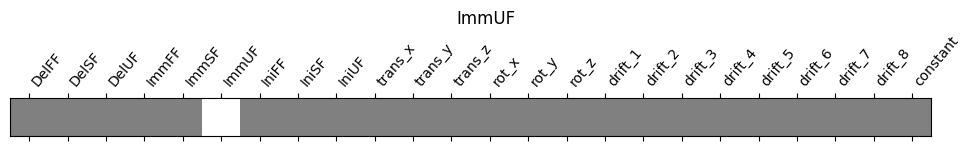

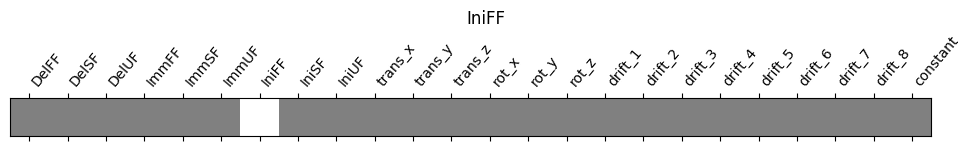

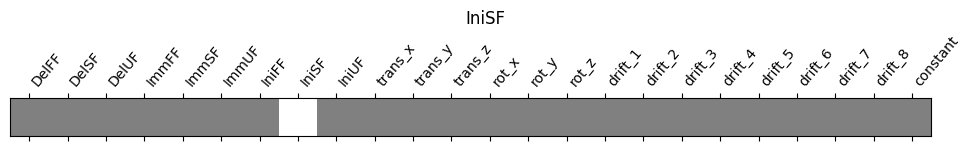

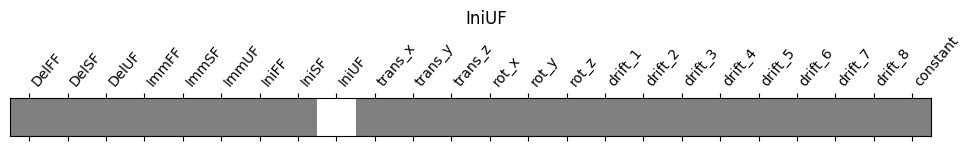

In [36]:
for key, values in basic_contrast_list[0].items():
    plot_contrast_matrix(values, design_matrix=design_matrices[0], colorbar=False)
    plt.suptitle(key)

plt.show()

## Computing contrasts and plotting result maps

With Nilearn, you can compute several different statistical maps from a contrast, including effect size maps, t-statistic maps, z-score maps, and more (see the [documentation](https://nilearn.github.io/dev/modules/generated/nilearn.glm.Contrast.html) for details).

**Effect size maps** correspond to the beta (or contrast estimate) maps. These represent the estimated size of the effect for a given condition or contrast. They are useful, for example, when plotting condition-specific betas in ROI analyses (see examples in the [ROI analysis notebook](nb06_ROI_analysis.ipynb)), or as inputs for [group-level analysis](nb05_Group-Level-Analysis.ipynb). 

For our single-subject analysis, we will now look at a **z-scored statistical map** for the **Faces > Scrambled** contrast. Z-scores tell us how strong the effect is relative to the noise level.

In [37]:
z_map = first_level_model.compute_contrast(
    [c['Faces_Scrambled'] for c in comparison_contrast_list], 
    output_type = 'z_score'
)

# You can save the z_map to a file
# z_map.to_filename('/path/to/output/z_map.nii.gz')

fMRI analyses involve thousands of voxel-wise comparisons, which increases the risk of false positives—famously illustrated by the case of the ["Dead Salmon"](https://teenspecies.github.io/pdfs/NeuralCorrelates.pdf).

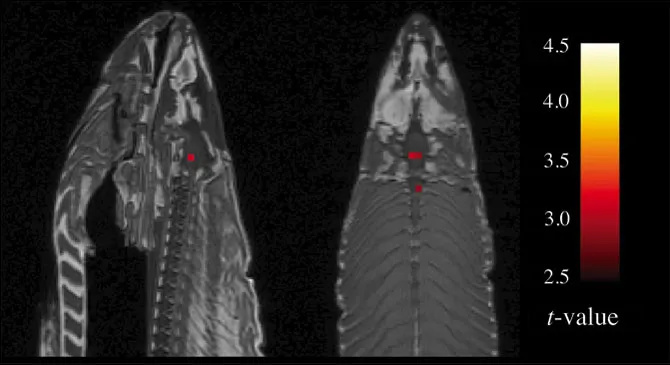

Applying a threshold, particularly one that corrects for multiple comparisons (e.g., using Family-Wise Error (FWE) or False Discovery Rate (FDR) corrections), helps ensure that the displayed activations are statistically reliable. For more information on multiple comparisons correction, see [Rik’s Stats tutorial](https://github.com/RikHenson/Stats4Imaging).

### Control the False Positive Rate

A minimum recommendation in the fMRI analysis is to control the **False Positive Rate** (FPR) at a specific threshold, such as p < .001. This is referred to as 'uncorrected' because it does not account for the number of multiple comparisons, but it can still help reduce false positives to a reasonable level when applied conservatively.

Uncorrected p<.001 threshold: 3.291


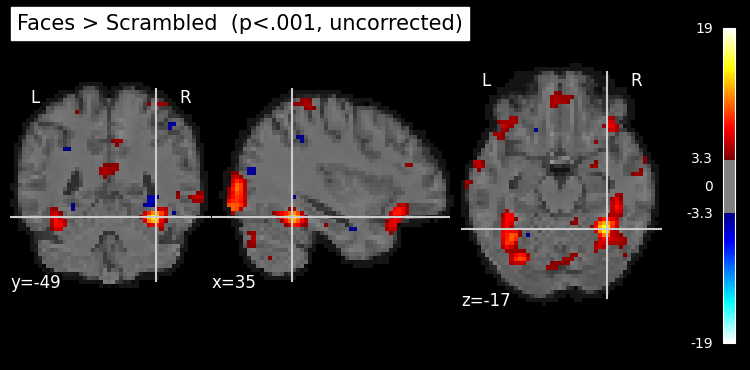

In [38]:
# Obtain the statistical threshold
_, threshold_fpr = threshold_stats_img(
    z_map, 
    alpha = .001, 
    height_control = 'fpr'
)

print('Uncorrected p<.001 threshold: %.3f' % threshold_fpr)

# plot the thresholded map
plot_stat_map(
    z_map, 
    bg_img = preprocessed_anatomical_file, 
    threshold = threshold_fpr,
    cut_coords=MNI_coord[0], # let's center the plot on our previously used example voxel
    display_mode = 'ortho', 
    black_bg = True,
    cmap = 'cold_hot',
    title = 'Faces > Scrambled  (p<.001, uncorrected)'
)
plt.show()

You can save the calculated map to a file:

In [39]:
# z_map.to_filename('../example_data/FaceRecognition/scratch/sub-15_z_map_faces_scrambled.nii.gz')

### False Discovery Rate (FDR) correction

A commonly used alternative to controlling the false positive rate is the **False Discovery Rate** (FDR) method, which addresses the expected proportion of false discoveries among all detected activations. In the case below, it is actually less strict than p<.001 uncorrected. However, in neuroimaging research, the appropriateness of FDR remains a topic of debate. While it is often preferred in exploratory or hypothesis-generating studies due to its balance between discovery and error control, it may be less suitable for confirmatory studies where stricter error control is required. See [Rik’s Stats tutorial](https://github.com/RikHenson/Stats4Imaging).

FDR, p<.05 threshold: 2.844


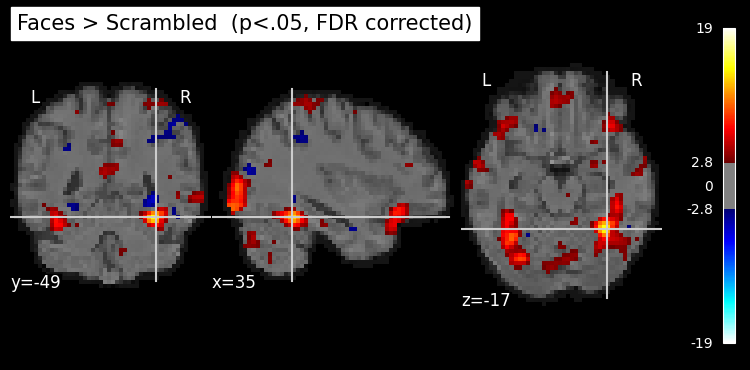

In [40]:
_, threshold_fdr = threshold_stats_img(
    z_map, 
    alpha = .05, 
    height_control = 'fdr'
)

print('FDR, p<.05 threshold: %.3f' % threshold_fdr)

plot_stat_map(
    z_map, 
    bg_img = preprocessed_anatomical_file, 
    threshold = threshold_fdr,
    cut_coords=MNI_coord[0], # let's center the plot on our previously used example voxel
    display_mode = 'ortho', 
    black_bg = True,
    cmap = 'cold_hot',
    title = 'Faces > Scrambled  (p<.05, FDR corrected)'
)
plt.show()

### Family Wise Error (FWE) correction

A more conservative approach is to control the **Family-Wise Error** (FWE) rate, which represents the probability of making one or more false discoveries, or Type I errors, across all tests. This rate is typically set at 5%. The **Bonferroni correction** is a commonly used method to achieve this level of control and is also used in Nilearn. 

In Nilearn, Bonferroni correction simply depends on the number of voxels. However, this is not ideal for fMRI data, because the voxels are typically spatially correlated (i.e., the data from nearby voxels are similar), whereas the Bonferroni correction assumes they are independent. As an alternative, neuroscientists have developed **Random Field Theory** (RFT). This method accounts for the spatial correlation by applying multiple comparison correction in a way that considers the smoothness of the data. Specifically, the correction is applied to the number of '***resels'*** (RESolution ELements), rather than the raw number of voxels. However, it's important to note that this **RFT-based approach is not implemented in Nilearn**. 

At the second-level analysis, Nilearn provides an option for non-parametric inference with permutation testing, which is a more suitable approach for fMRI data, considering the spatial correlation of voxels. 

Bonferroni-corrected, p<.05 threshold: 4.952


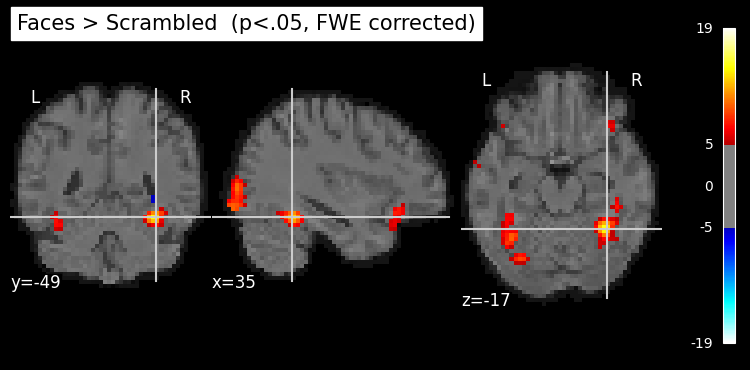

In [41]:
_, threshold_fwe = threshold_stats_img(
    z_map, 
    alpha = .05, 
    height_control = 'bonferroni')

print('Bonferroni-corrected, p<.05 threshold: %.3f' % threshold_fwe)

plot_stat_map(
    z_map, 
    bg_img = preprocessed_anatomical_file, 
    threshold = threshold_fwe,
    cut_coords=MNI_coord[0], # let's center the plot on our previously used example voxel
    display_mode = 'ortho', 
    black_bg = True,
    cmap = 'cold_hot',
    title = 'Faces > Scrambled  (p<.05, FWE corrected)'
)
plt.show()

### Cluster threshold

It's a common practice to discard isolated voxels from the images. It is possible to generate a thresholded map with small clusters removed by providing a `cluster_threshold` argument. Below, clusters smaller than `200` voxels will be discarded from the `fpr` corrected map. [Rik's Stats tutorial](https://github.com/RikHenson/Stats4Imaging) describes way to estimate this threshold for spatial extent (and also considers threshold-free cluster enhancement).

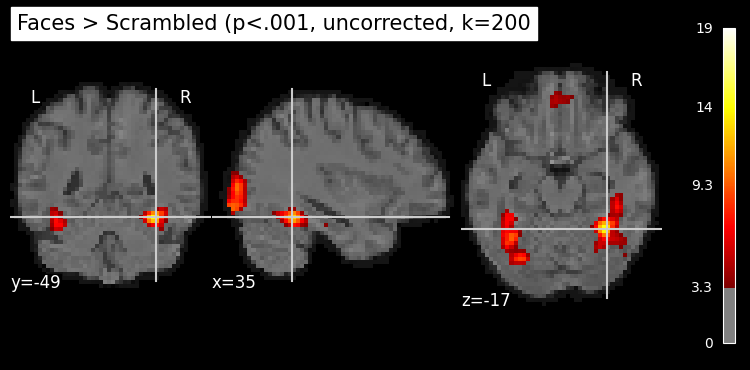

In [42]:
thresholded_map_fpr, threshold_fpr = threshold_stats_img(
    z_map, 
    alpha = .001, 
    height_control='fpr', 
    cluster_threshold = 200
)

plot_stat_map(
    thresholded_map_fpr, 
    bg_img = preprocessed_anatomical_file, 
    threshold = threshold_fpr,
    cut_coords=MNI_coord[0], # let's center the plot on our previously used example voxel
    display_mode = 'ortho', 
    black_bg = True, 
    cmap = 'hot',
    colorbar = True,
    title = 'Faces > Scrambled (p<.001, uncorrected, k=200'
)
plt.show()

Finally, let's look at where activation is greater for famous than unfamiliar faces:

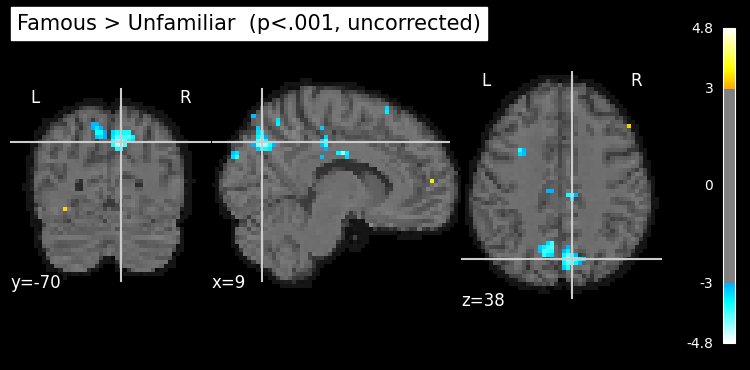

In [43]:
z_map = first_level_model.compute_contrast(
    [c['Famous_Unfamiliar'] for c in comparison_contrast_list], 
    output_type = 'z_score'
)

# Obtain the statistical threshold
_, threshold_fpr = threshold_stats_img(
    z_map, 
    alpha = .001, 
    height_control = None
)

# plot the thresholded map
plot_stat_map(
    z_map, 
    bg_img = preprocessed_anatomical_file, 
    threshold = threshold_fpr,
    display_mode = 'ortho', 
    black_bg = True,
    cmap = 'cold_hot',
    title = 'Famous > Unfamiliar  (p<.001, uncorrected)'
)
plt.show()

There are some hints at an uncorrected level, but if you play with threshold, you can see that they are unlikely to survive correction.

## First Level for multiple subjects

### A generic first-level analysis script

Using a notebook like this is an effective method for preparing the final analysis script. Now, we can combine all the elements discussed into a unified, generic script that will conduct the first-level analysis.

**Example of a generic first-level script**: [/code-examples/first_level_script.py](../code-examples/first_level_script.py)

**Things to note:**
* We are saving the result files in BIDS format so that they can be easily queried with PyBIDS for further analysis.
* We are generating a *dataset_description.json* file for the result model, which is required to make the results directory BIDS-compatible. This file will also contain our model parameters, which is useful for understanding how the results were obtained.

**Main steps:**
1. Specify the input and output paths and the subject's ID. The input should be the BIDS dataset, which contains the derivatives folder with fmriprep's preprocessed data.
2. Specify the subject's preprocessed functional, event, and confound files.
3. Specify the confounds of interest.
4. Specify the first-level model parameters and fit the model.
5. Specify the contrasts (in this example, the contrasts include Faces > Scrambled, Effects of Interest, and single contrasts for each of the nine conditions).
6. Compute the contrasts and save the results in BIDS format.
7. Create the model's *dataset_description.json* file.

```python
# Example usage:
# python first_level_script.py /path/to/bids/dataset sub-01 /path/to/output
# ======================================================================

# ======================================================================
# IMPORT REQUIRED PACKAGES
# ======================================================================
import os
import sys
import pandas as pd
import numpy as np
from bids.layout import BIDSLayout
from nilearn.glm.first_level import FirstLevelModel
import time
import warnings
warnings.filterwarnings("ignore")

# ======================================================================
# DEFINE PATHS
# arguments passed to the script
# ======================================================================
bids_path = sys.argv[1] # BIDS path
subject = sys.argv[2] # including sub- prefix
output = sys.argv[3] # output directory

# ======================================================================
sID = subject.split("sub-")[1] # remove 'sub-' prefix

print("Running first-level analysis for " + subject)
start_time = time.time()
print("Started at: " + time.strftime("%H:%M:%S", time.localtime()))

# ======================================================================
# DEFINE PARAMETERS
# =====================================================================
# Define the model name and output directory
model_name = 'first-level'
outdir = os.path.join(output, model_name, subject)

# Define the preprocessed space to use
preprocessed_space = 'MNI152NLin6Asym'
space_res = '9'

# Define which confounds to include in the GLM
confounds_of_interest = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']


# ======================================================================
# PERFORM SUBJECT LEVEL GLM ANALYSIS
# ======================================================================
os.makedirs(outdir, exist_ok=True)

print("BIDS data location: " + bids_path)
print("Output directory: " + outdir)

# --- Initialize the BIDS layout and include the derivatives in it
layout = BIDSLayout(bids_path, derivatives=True)

# --- Get the preprocessed functional files
bold = layout.get(
    subject=sID, 
    datatype='func', 
    space=preprocessed_space, 
    res=space_res,
    desc='preproc', 
    extension='.nii.gz',
    return_type='filename'
    )
print("Found " + str(len(bold)) + " preprocessed functional files")

# --- Get the event files
events = layout.get(
    subject=sID, 
    datatype='func', 
    suffix='events', 
    extension=".tsv", 
    return_type='filename'
    )
print("Found " + str(len(events)) + " event files")

# --- Get the confounds
confounds = layout.get(
    subject=sID, 
    datatype='func', 
    desc='confounds', 
    extension=".tsv", 
    return_type='filename'
    )
print("Found " + str(len(confounds)) + " confounds files")

# --- Get the brain mask
brain_mask = layout.get(
    subject=sID, 
    datatype='anat', 
    suffix='mask', 
    desc='brain', 
    space=preprocessed_space, 
    res=space_res,
    extension='.nii.gz',
    return_type='filename'
    )
print("Found " + str(len(brain_mask)) + " brain mask files")

# Check if any of the required data is missing
if len(bold) == 0 or len(events) == 0 or len(confounds) == 0 or len(brain_mask) == 0:
    print("ERROR: Missing required data (BOLD, events, confounds files, or brain mask) for subject " + sID)
    print("BOLD files: " + str(len(bold)))
    print("Event files: " + str(len(events)))
    print("Confound files: " + str(len(confounds)))
    print("Brain mask files: " + str(len(brain_mask)))
    sys.exit(1)

# --- For each run, load the confounds and select the ones of interest
confounds_glm = []
for conf_file in confounds:
    this_conf = pd.read_table(conf_file)
    # only include the confounds of interest that are present in the file
    confounds_of_interest = [conf for conf in confounds_of_interest if conf in this_conf.columns]
    # select the confounds of interest and fill NaN with 0    
    conf_subset = this_conf[confounds_of_interest].fillna(0) # replace NaN with 0
    confounds_glm.append(conf_subset)

# --- Get the TR value
TR = layout.get_tr()

# --- If slice timing correction was applied, get the slice time reference
slice_timing = layout.get_metadata(bold[0])
if slice_timing['SliceTimingCorrected']:
  slice_time_ref = slice_timing['StartTime'] / TR
else:
  slice_time_ref = 0

# --- Define the GLM model
fmri_glm = FirstLevelModel(
    t_r = TR,
    slice_time_ref = slice_time_ref, 
    hrf_model = 'SPM',
    drift_model = 'cosine',
    high_pass = 0.01,
    noise_model = 'ar1',
    smoothing_fwhm = 6
    )

# --- Fit the model
fmri_glm = fmri_glm.fit(bold, events, confounds_glm)

# --- Get the design matrices
design_matrices = fmri_glm.design_matrices_

# --- Create contrasts 
events_df = pd.read_table(events[0])
unique_conditions = events_df['trial_type'].unique()

contrast_list = []
nruns = len(design_matrices)

for design_matrix in design_matrices:
    n_columns = design_matrix.shape[1]  # number of predictors in the model
    column_names = design_matrix.columns  # get the names of the columns
    
    # Create an empty dictionary to store contrasts for all conditions
    contrasts = {}
    
    # ------------------------------------------------------------------
    # Create a contrast vector for each condition
    # ------------------------------------------------------------------
    for condition in unique_conditions:
        # Initialize the contrast vector with zeros
        contrast_vector = np.zeros(n_columns)
        
        # Assign 1 to the columns that correspond to the current condition and scale by the number of runs
        for i, col_name in enumerate(column_names):
            if col_name.startswith(condition):
                contrast_vector[i] = 1/nruns
        
        # Store the contrast for the current condition
        contrasts[condition] = contrast_vector
        
    # ------------------------------------------------------------------
    # Create contrast for Faces > Scrambled
    # ------------------------------------------------------------------
    # Calculate the number of "Faces" and "Scrambled" conditions
    num_faces = sum(1 for col_name in column_names if col_name.endswith(('FF', 'UF')))
    num_scrambled = sum(1 for col_name in column_names if col_name.endswith('SF'))
    
    # Initialize the contrast vector with zeros
    contrast_vector = np.zeros(n_columns)
    
    # Assign weights to the contrast vector
    for i, col_name in enumerate(column_names):
        if col_name.endswith(('FF', 'UF')):
            contrast_vector[i] = 1 / num_faces /nruns # weigh the faces conditions
        elif col_name.endswith('SF'):
            contrast_vector[i] = -1 / num_scrambled/nruns  # weigh the scrambled conditions
    
    contrasts['FacesScrambled'] = contrast_vector
    
    # ------------------------------------------------------------------
    # Create effects of interest contrast
    # ------------------------------------------------------------------
    contrasts['EffectsOfInterest'] = np.eye(n_columns)[:len(unique_conditions)]
    
    # Append all contrasts for this design matrix
    contrast_list.append(contrasts)
    
# --- Compute the contrasts and save the results
for contrast_id in contrast_list[0].keys():   
    if contrast_id == 'EffectsOfInterest':
        stats = 'z_score' 
    else:
        stats = 'effect_size'
    stats_map = fmri_glm.compute_contrast(
        [c[contrast_id] for c in contrast_list], 
        output_type = stats)
    # Save results following BIDS standart
    res_name = os.path.basename(bold[0]).split("run")[0]
    # from stats get only the part before _ for the BIDS file name
    stats_suffix = stats.split("_")[0]
    # in contrast_id remove underscores
    contrast_id = contrast_id.replace("_", "")
    # Save the result
    stats_map.to_filename(os.path.join(outdir, res_name + 'desc-' + contrast_id + '_' + stats_suffix + '.nii.gz'))

# ======================================================================
# CREATE THIS MODEL'S dataset_description.json FILE
# This is needed to use the results directory as BIDS data. 
# We will save our model parameters in the file as well, which is very useful.
# ======================================================================

jason_file = os.path.join(output, model_name, "dataset_description.json")

if not os.path.exists(jason_file):
    import json
    import datetime
    from importlib.metadata import version

    bids_version = layout.get_dataset_description()['BIDSVersion']
    nilearn_version = version('nilearn')
    date_created = datetime.datetime.now()
    
    # Data to be written
    content = {
        "Name": "First-level GLM analysis",
        "BIDSVersion": bids_version,
        "DatasetType": "results",
        "GeneratedBy": [
            {
                "Name": "Nilearn",
                "Version": nilearn_version,
                "CodeURL": "https://nilearn.github.io"
            }
        ],    
        "Date": date_created,
        "ConfoundsIncluded": confounds_of_interest,
        "FirstLevelModel": [
            fmri_glm.get_params()
        ], 
    }
    
    # Serializing json
    json_object = json.dumps(content, indent=4, default=str)
    
    # Writing to .json
    with open(jason_file, "w") as outfile:
        outfile.write(json_object)

# ======================================================================
print("Finished first-level analysis for " + subject)
print("Finished at: " + time.strftime("%H:%M:%S", time.localtime()))
print("Processing time: " + str(round((time.time() - start_time)/60, 2)) + " minutes")

```

### Processing multiple subjects in parallel

#### Using `SLURM`
  
If `SLURM `is available on the system, you can create a project-specific script where you define the paths and use the `sbatch` command to execute the generic script for each subject in parallel.

**Example script**: [/code-examples/step07_first_level_analysis.sh](../code-examples/step07_first_level_analysis.sh)

If `SLURM` is not available, you can still process multiple subjects in parallel using alternative methods depending on the system you're working with.
  
#### Using Python's `multiprocessing` Module
  
Python's `multiprocessing` module allows you to run processes in parallel on your local machine, distributing the workload across multiple CPU cores. An advantage is that it can be run on a single machine without needing a cluster or SLURM. A disatvantage is that it is limited by the local resources (RAM, CPU), and not ideal for very large datasets or many subjects.
Here is an example how you could use the `multiprocessing` module:

```python
import multiprocessing as mp
import os

# Define a function to process a single subject
def process_subject(subject_id, dataset_location, output_dir):
    # Execute the first-level script with the appropriate arguments
    os.system(f"python first_level_script.py {dataset_location} sub-{subject_id} {output_dir}")

# Define the dataset location and output directory
dataset_location = "/path/to/bids_dataset"
output_dir = "/path/to/output"

# List of subject IDs
subjects = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16']
# subjects = [f"{i:02d}" for i in range(1, 17)]

# Create a pool of processes using the available CPU cores
if __name__ == '__main__':
    pool = mp.Pool(mp.cpu_count())  # Use all available CPU cores

    # Use pool.starmap to pass multiple arguments to the process_subject function
    pool.starmap(process_subject, [(subject, dataset_location, output_dir) for subject in subjects])

    # Close the pool and wait for the processes to complete
    pool.close()
    pool.join()

  ```

#### Using Cloud Services
  
If you don’t have SLURM or a powerful local machine, cloud computing platforms (e.g., AWS, Google Cloud, Microsoft Azure) allow you to run parallel processes with scalable resources. You can set up virtual machines or use a service like AWS Batch or Google Cloud Dataflow to handle parallel jobs across multiple subjects. However, it requires cloud expertise and comes with costs.